In [7]:
# Prueba 3 - Participación menor al 20%, con class_weight
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Cargar datos
df = pd.read_excel("datos_modelo_GRD.xlsx")

# 2️⃣ Imputación de valores nulos
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna('Desconocido', inplace=True)

# 3️⃣ Definir variables predictoras
features = [
    'Edad', 'Sexo', 'Tipo de ingreso', 'Dx principal de egreso', 'Duración estancia',
    'Días de Unidad Cuidado Intensivo', 'Infecciones', 'Situacion al alta',
    'Num_Procedimientos', 'Tipo servicio'
]
X = pd.get_dummies(df[features])

# 4️⃣ Preparar etiquetas (GRD - Código)
y_raw = df['GRD -Código'].astype(str)

# Filtrar GRDs frecuentes (≥ 20% del GRD más frecuente)
grd_counts = y_raw.value_counts()
umbral = grd_counts.max() * 0.20
grds_frec = grd_counts[grd_counts >= umbral].index
y_filtered = y_raw.where(y_raw.isin(grds_frec), 'OTRO')

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)

# Eliminar clases con solo 1 muestra (modelo no puede entrenar con ellas)
mask = [Counter(y_encoded)[label] > 1 for label in y_encoded]
X = X[mask]
y_encoded = y_encoded[mask]

# 5️⃣ Dividir conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# 6️⃣ Escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ⚖️ Calcular pesos por clase
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train),
                                     y=y_train)
class_weight_dict = {i: w for i, w in zip(np.unique(y_train), class_weights)}

# 7️⃣ Definir modelo (Model_2: 128-64-32) con class_weight
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    activation='relu',
                    solver='adam',
                    alpha=0.001,
                    batch_size=32,
                    learning_rate='adaptive',
                    max_iter=100,
                    early_stopping=True,
                    validation_fraction=0.1,
                    n_iter_no_change=10,
                    random_state=42,
                    verbose=True)

# 8️⃣ Entrenar modelo con pesos
mlp.fit(X_train, y_train, sample_weight=np.array([class_weight_dict[y] for y in y_train]))

# 9️⃣ Evaluación
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 🔟 Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - MLPClassifier (Model_2 + class_weight)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.tight_layout()
plt.show()

# 🔟 Curvas ROC por clase
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
plt.figure(figsize=(8, 6))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC por clase - MLPClassifier')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


TypeError: BaseMultilayerPerceptron.fit() got an unexpected keyword argument 'sample_weight'

Iteration 1, loss = 1.14665954
Validation score: 0.748430
Iteration 2, loss = 0.63674763
Validation score: 0.747085
Iteration 3, loss = 0.57609416
Validation score: 0.737668
Iteration 4, loss = 0.55690896
Validation score: 0.753363
Iteration 5, loss = 0.54215443
Validation score: 0.752466
Iteration 6, loss = 0.53280327
Validation score: 0.729596
Iteration 7, loss = 0.52647785
Validation score: 0.736771
Iteration 8, loss = 0.51835802
Validation score: 0.731839
Iteration 9, loss = 0.51432618
Validation score: 0.746637
Iteration 10, loss = 0.51016473
Validation score: 0.739462
Iteration 11, loss = 0.50578616
Validation score: 0.737220
Iteration 12, loss = 0.49988150
Validation score: 0.733184
Iteration 13, loss = 0.49904284
Validation score: 0.747085
Iteration 14, loss = 0.49586939
Validation score: 0.756502
Iteration 15, loss = 0.48830584
Validation score: 0.747085
Iteration 16, loss = 0.48631142
Validation score: 0.738117
Iteration 17, loss = 0.48888754
Validation score: 0.733632
Iterat

C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

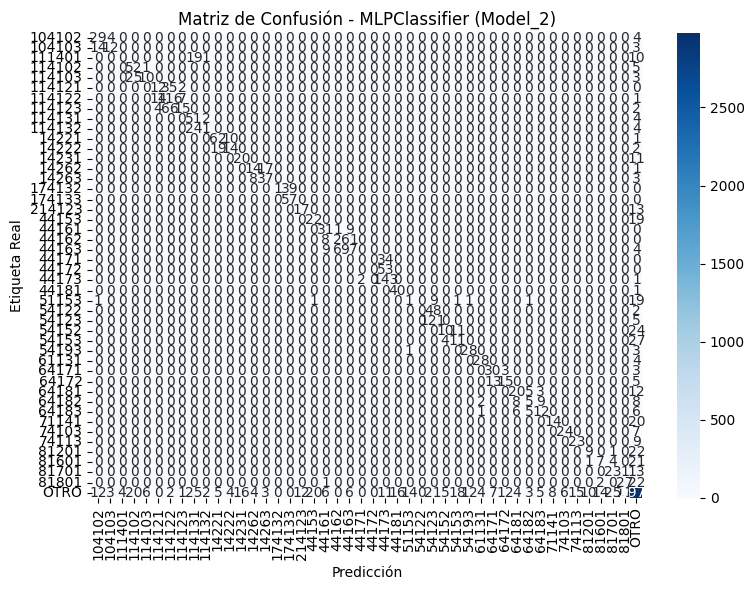

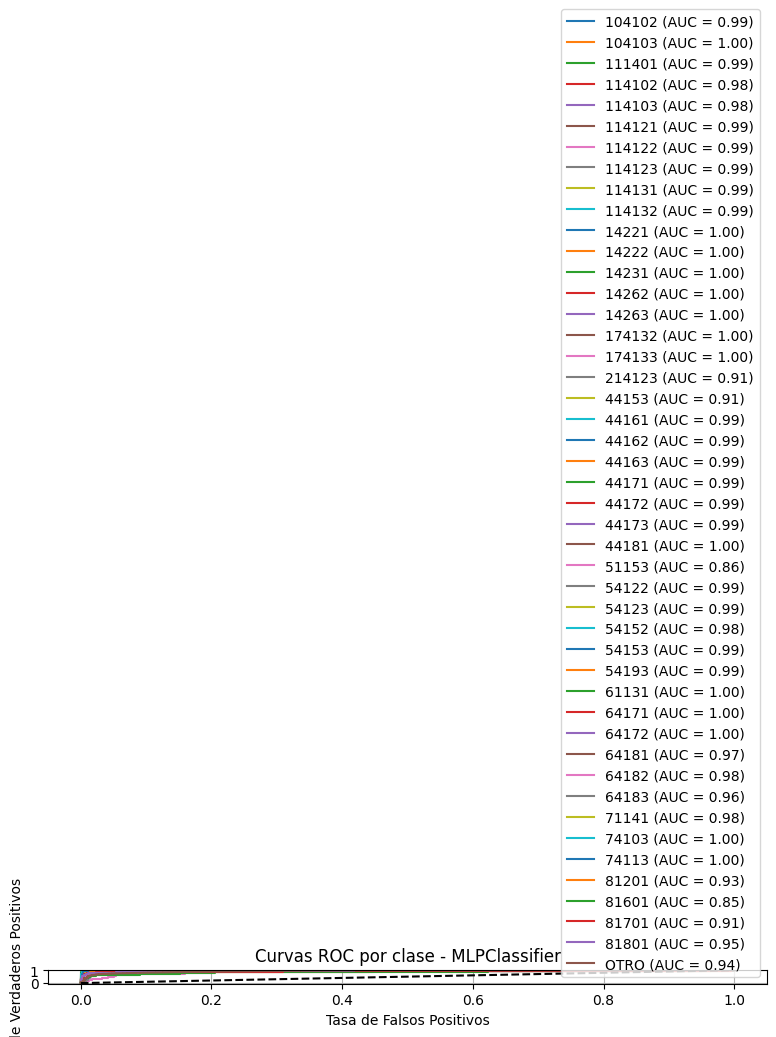

In [1]:

##prueba 2 

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Cargar datos
df = pd.read_excel("datos_modelo_GRD.xlsx")

# 2️⃣ Imputación de valores nulos
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna('Desconocido', inplace=True)

# 3️⃣ Definir variables predictoras
features = [
    'Edad', 'Sexo', 'Tipo de ingreso', 'Dx principal de egreso', 'Duración estancia',
    'Días de Unidad Cuidado Intensivo', 'Infecciones', 'Situacion al alta',
    'Num_Procedimientos', 'Tipo servicio'
]
X = pd.get_dummies(df[features])

# 4️⃣ Preparar etiquetas (GRD - Código)
y_raw = df['GRD -Código'].astype(str)

# Filtrar GRDs frecuentes (≥ 20% del GRD más frecuente)
grd_counts = y_raw.value_counts()
umbral = grd_counts.max() * 0.20
grds_frec = grd_counts[grd_counts >= umbral].index
y_filtered = y_raw.where(y_raw.isin(grds_frec), 'OTRO')

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)

# Eliminar clases con solo 1 muestra
mask = [Counter(y_encoded)[label] > 1 for label in y_encoded]
X = X[mask]
y_encoded = y_encoded[mask]

# 5️⃣ Dividir conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# 6️⃣ Escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 7️⃣ Definir modelo (arquitectura Model_2: 128-64-32)
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    activation='relu',
                    solver='adam',
                    alpha=0.001,
                    batch_size=32,
                    learning_rate='adaptive',
                    max_iter=100,
                    early_stopping=True,
                    validation_fraction=0.1,
                    n_iter_no_change=10,
                    random_state=42,
                    verbose=True)

# 8️⃣ Entrenar modelo
mlp.fit(X_train, y_train)

# 9️⃣ Evaluación
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 🔟 Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - MLPClassifier (Model_2)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.tight_layout()
plt.show()

# 🔟 Curvas ROC por clase
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
plt.figure(figsize=(8,6))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC por clase - MLPClassifier')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

 

Iteration 1, loss = 1.14665954
Validation score: 0.748430
Iteration 2, loss = 0.63674763
Validation score: 0.747085
Iteration 3, loss = 0.57609416
Validation score: 0.737668
Iteration 4, loss = 0.55690896
Validation score: 0.753363
Iteration 5, loss = 0.54215443
Validation score: 0.752466
Iteration 6, loss = 0.53280327
Validation score: 0.729596
Iteration 7, loss = 0.52647785
Validation score: 0.736771
Iteration 8, loss = 0.51835802
Validation score: 0.731839
Iteration 9, loss = 0.51432618
Validation score: 0.746637
Iteration 10, loss = 0.51016473
Validation score: 0.739462
Iteration 11, loss = 0.50578616
Validation score: 0.737220
Iteration 12, loss = 0.49988150
Validation score: 0.733184
Iteration 13, loss = 0.49904284
Validation score: 0.747085
Iteration 14, loss = 0.49586939
Validation score: 0.756502
Iteration 15, loss = 0.48830584
Validation score: 0.747085
Iteration 16, loss = 0.48631142
Validation score: 0.738117
Iteration 17, loss = 0.48888754
Validation score: 0.733632
Iterat

C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

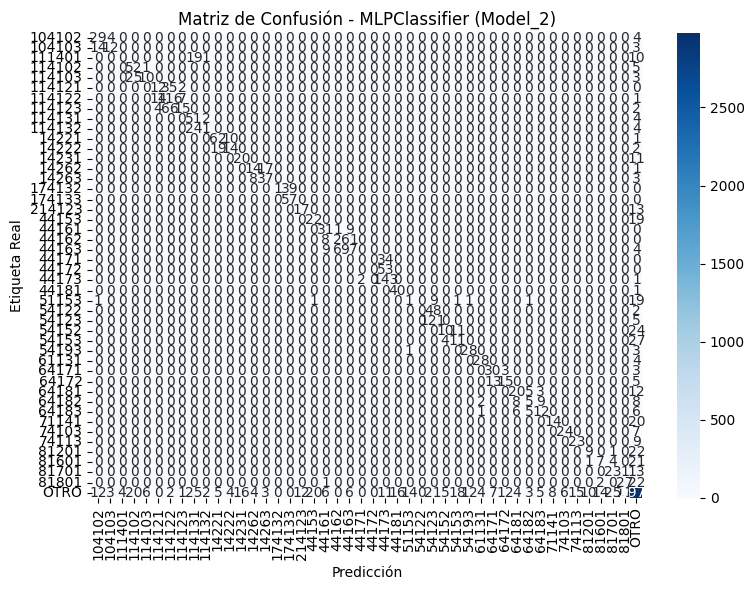

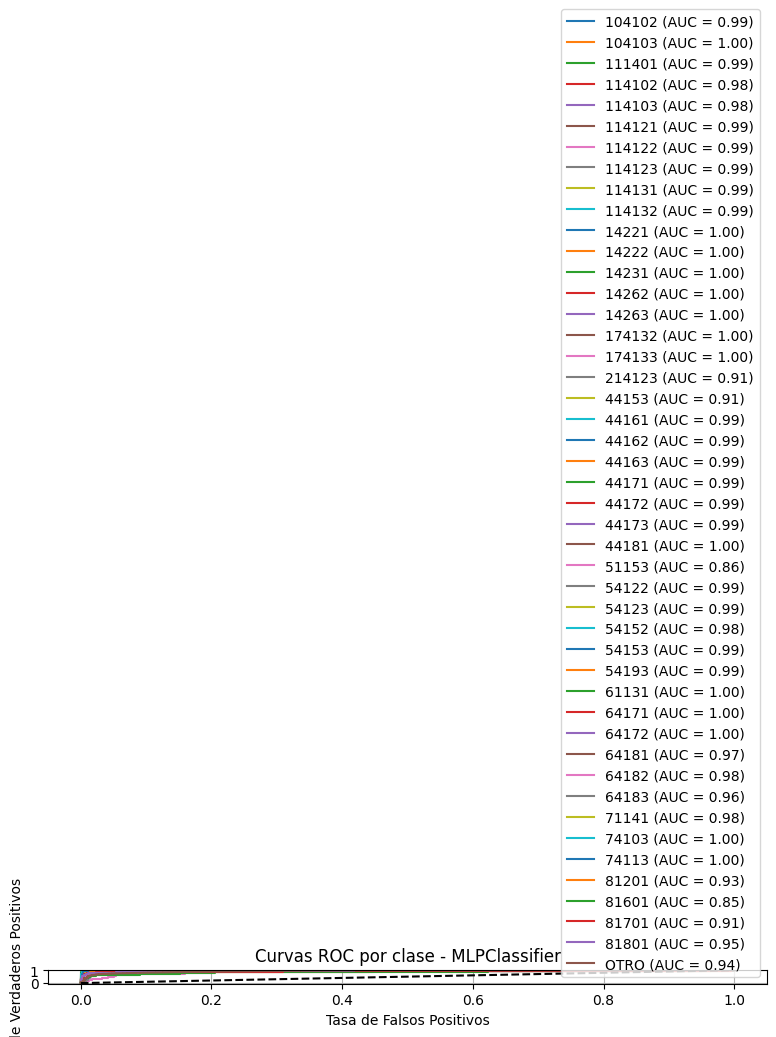

In [4]:
# prueba 3 - participacion menor 20%
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Cargar datos
df = pd.read_excel("datos_modelo_GRD.xlsx")

# 2️⃣ Imputación de valores nulos
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna('Desconocido', inplace=True)

# 3️⃣ Definir variables predictoras
features = [
    'Edad', 'Sexo', 'Tipo de ingreso', 'Dx principal de egreso', 'Duración estancia',
    'Días de Unidad Cuidado Intensivo', 'Infecciones', 'Situacion al alta',
    'Num_Procedimientos', 'Tipo servicio'
]
X = pd.get_dummies(df[features])

# 4️⃣ Preparar etiquetas (GRD - Código)
y_raw = df['GRD -Código'].astype(str)

# Filtrar GRDs frecuentes (≥ 20% del GRD más frecuente)
grd_counts = y_raw.value_counts()
umbral = grd_counts.max() * 0.20
grds_frec = grd_counts[grd_counts >= umbral].index
y_filtered = y_raw.where(y_raw.isin(grds_frec), 'OTRO')

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y_filtered)

# Eliminar clases con solo 1 muestra (modelo no puede entrenar con ellas)
mask = [Counter(y_encoded)[label] > 1 for label in y_encoded]
X = X[mask]
y_encoded = y_encoded[mask]

# 5️⃣ Dividir conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# 6️⃣ Escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 7️⃣ Definir modelo (arquitectura Model_2: 128-64-32)
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    activation='relu',
                    solver='adam',
                    alpha=0.001,
                    batch_size=32,
                    learning_rate='adaptive',
                    max_iter=100,
                    early_stopping=True,
                    validation_fraction=0.1,
                    n_iter_no_change=10,
                    random_state=42,
                    verbose=True)

# 8️⃣ Entrenar modelo
mlp.fit(X_train, y_train)

# 9️⃣ Evaluación
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 🔟 Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - MLPClassifier (Model_2)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.tight_layout()
plt.show()

# 🔟 Curvas ROC por clase
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
plt.figure(figsize=(8,6))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC por clase - MLPClassifier')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()







Iteration 1, loss = 0.48111608
Validation score: 0.822422
Iteration 2, loss = 0.36908299
Validation score: 0.817040
Iteration 3, loss = 0.35074674
Validation score: 0.795964
Iteration 4, loss = 0.34311995
Validation score: 0.783408
Iteration 5, loss = 0.33724304
Validation score: 0.816143
Iteration 6, loss = 0.33317033
Validation score: 0.792377
Iteration 7, loss = 0.33162681
Validation score: 0.793722
Iteration 8, loss = 0.32776392
Validation score: 0.804484
Iteration 9, loss = 0.32595444
Validation score: 0.825112
Iteration 10, loss = 0.32365300
Validation score: 0.806278
Iteration 11, loss = 0.32139696
Validation score: 0.832287
Iteration 12, loss = 0.31937520
Validation score: 0.818386
Iteration 13, loss = 0.31752062
Validation score: 0.819283
Iteration 14, loss = 0.31549109
Validation score: 0.832287
Iteration 15, loss = 0.31354376
Validation score: 0.827803
Iteration 16, loss = 0.31170682
Validation score: 0.830045
Iteration 17, loss = 0.30881848
Validation score: 0.829596
Iterat

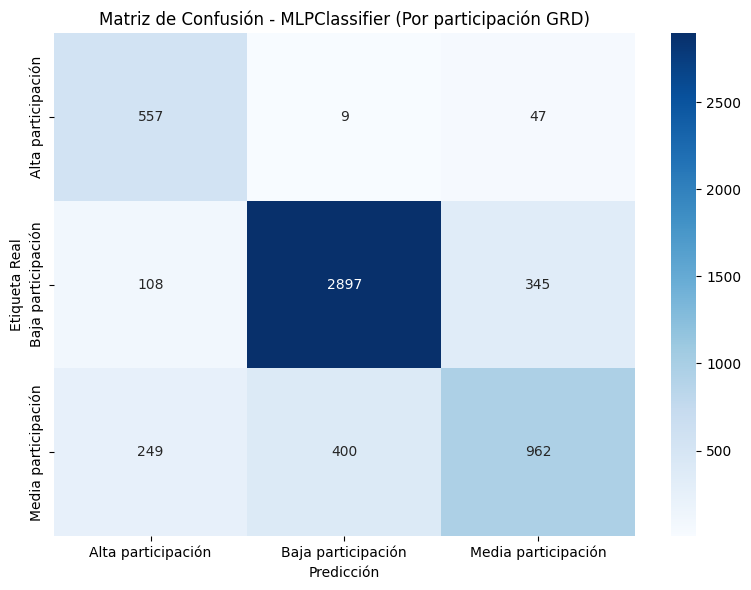

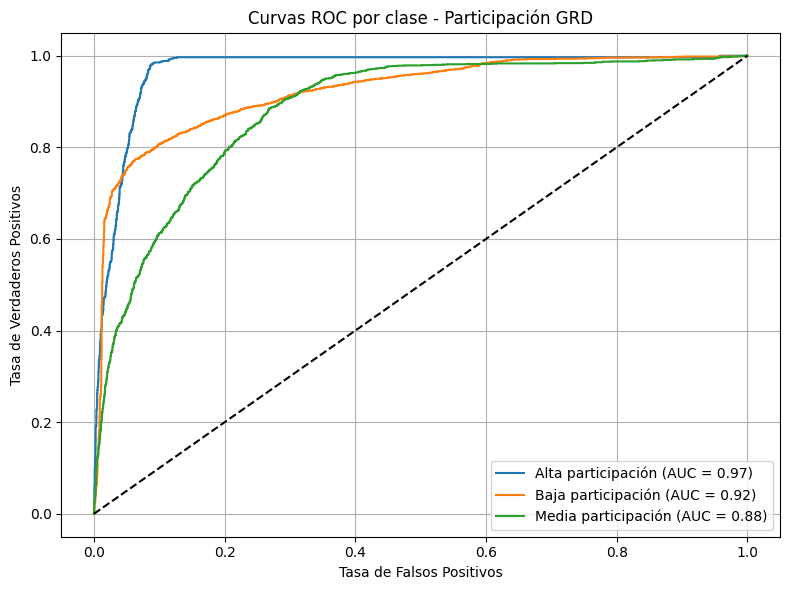

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Cargar datos
df = pd.read_excel("datos_modelo_GRD.xlsx")

# 2️⃣ Imputación de valores nulos
df.fillna(df.mean(numeric_only=True), inplace=True)
df.fillna('Desconocido', inplace=True)

# 3️⃣ Definir variables predictoras
features = [
    'Edad', 'Sexo', 'Tipo de ingreso', 'Dx principal de egreso', 'Duración estancia',
    'Días de Unidad Cuidado Intensivo', 'Infecciones', 'Situacion al alta',
    'Num_Procedimientos', 'Tipo servicio'
]
X = pd.get_dummies(df[features])

# 4️⃣ Preparar etiquetas de participación
y_raw = df['GRD -Código'].astype(str)
grd_counts = y_raw.value_counts()
max_count = grd_counts.max()

# Clasificación por participación relativa
participation = y_raw.map(grd_counts) / max_count

# Asignar clases según los umbrales
def clasificar_participacion(p):
    if p < 0.20:
        return 'Baja participación'
    elif 0.20 <= p <= 0.50:
        return 'Media participación'
    else:
        return 'Alta participación'

y_participacion = participation.apply(clasificar_participacion)

# Codificar etiquetas
le = LabelEncoder()
y_encoded = le.fit_transform(y_participacion)

# Eliminar clases con solo 1 muestra
mask = [Counter(y_encoded)[label] > 1 for label in y_encoded]
X = X[mask]
y_encoded = y_encoded[mask]

# 5️⃣ Dividir conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# 6️⃣ Escalado
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 7️⃣ Modelo MLP
mlp = MLPClassifier(hidden_layer_sizes=(128, 64, 32),
                    activation='relu',
                    solver='adam',
                    alpha=0.001,
                    batch_size=32,
                    learning_rate='adaptive',
                    max_iter=100,
                    early_stopping=True,
                    validation_fraction=0.1,
                    n_iter_no_change=10,
                    random_state=42,
                    verbose=True)

# 8️⃣ Entrenar modelo
mlp.fit(X_train, y_train)

# 9️⃣ Evaluación
y_pred = mlp.predict(X_test)
y_pred_proba = mlp.predict_proba(X_test)

print("\n📋 Reporte de clasificación:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# 🔟 Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión - MLPClassifier (Por participación GRD)")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.tight_layout()
plt.show()

# 🔟 Curvas ROC por clase
y_test_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
plt.figure(figsize=(8,6))
for i in range(len(le.classes_)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{le.classes_[i]} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('Curvas ROC por clase - Participación GRD')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
